In [492]:
from detectdd import config
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras

import root_config as rc
import pandas as pd
from detectdd.serializer import Serializer

from sklearn.model_selection import train_test_split

rc.configure()



### Pipeline selection
The data array and the features in the csv need to match, so uncomment both of them out


In [493]:
# Switch between different csv files, haven't automated detection of this yet. The data array
# needs to match the feature columns in the csv, or those features will be ignored.

##### uncomment this set of features and 
data_arrays = ["heart_rate", "sbp", "dbp", "mbp"]
vitals_data_df = pd.read_csv(config.out_dir / 'vitals_data_before_and_after.csv')
vitals_no_ddi = pd.read_csv(config.out_dir / 'vitals_data_no_drug_interaction.csv')

# data_arrays = ["heart_rate", "sbp", "dbp", "mbp", "uric acid", "creatinine"]
# vitals_data_df = pd.read_csv('vitals_kidney_data.csv')

print(vitals_data_df.dtypes)

print(f"Duplicates found: {vitals_no_ddi[vitals_no_ddi['subject_id'].isin(vitals_data_df['subject_id'])]['subject_id'].nunique()}")
vitals_no_ddi = vitals_no_ddi[~vitals_no_ddi['subject_id'].isin(vitals_data_df['subject_id'])]
print(f"Remaining duplicates: {vitals_no_ddi[vitals_no_ddi['subject_id'].isin(vitals_data_df['subject_id'])]['subject_id'].nunique()}")
vitals_data_df.head(500)

Unnamed: 0       int64
stay_id          int64
dose_b_time     object
subject_id       int64
charttime       object
heart_rate     float64
sbp            float64
dbp            float64
mbp            float64
dtype: object
Duplicates found: 2161
Remaining duplicates: 0


,Unnamed: 0,stay_id,dose_b_time,subject_id,charttime,heart_rate,sbp,dbp,mbp
0,0,30000484,2136-01-15 00:59:00,18421337,2136-01-15 03:00:00,84.0,90.0,44.0,54.0
1,1,30000484,2136-01-15 00:59:00,18421337,2136-01-15 07:00:00,83.0,88.0,38.0,50.0
2,2,30000484,2136-01-15 00:59:00,18421337,2136-01-15 09:00:00,83.0,111.0,23.0,46.0
3,3,30000484,2136-01-15 00:59:00,18421337,2136-01-15 08:00:00,90.0,113.0,61.0,75.0
4,4,30000484,2136-01-15 00:59:00,18421337,2136-01-14 18:38:00,106.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
495,495,30031686,2144-10-31 16:00:00,18284271,2144-10-31 20:00:00,76.0,156.0,67.0,88.0
496,496,30031686,2144-10-31 16:00:00,18284271,2144-10-31 14:45:00,75.0,110.0,52.0,66.0
497,497,30031686,2144-10-31 16:00:00,18284271,2144-10-31 14:30:00,77.0,120.0,52.0,68.0
498,498,30031686,2144-10-31 16:00:00,18284271,2144-10-31 13:15:00,82.0,120.0,62.0,70.0


In [494]:
def fix_csv_data_types(df):
    df["charttime"] = df["charttime"].astype("datetime64[s]")
    df["dose_b_time"] = df["dose_b_time"].astype("datetime64[s]")
    return df

vitals_data_df = fix_csv_data_types(vitals_data_df)
vitals_no_ddi = fix_csv_data_types(vitals_no_ddi)

vitals_data_df = vitals_data_df.sort_values(by=["stay_id", "dose_b_time", "charttime"])

try:
    serializer = Serializer()
    cohort_with_icd = serializer.read_cohort()  # need to run 01-cohort.ipynb to produce the cohort
except FileNotFoundError:
    raise Exception("Need to run [01-cohort.ipynb] at least once to create the cohort file in the /out directory")



print(vitals_data_df.describe())
print(vitals_no_ddi.describe())
vitals_data_df.head(500)



Loaded cohort from ..\out\cohort-full.out
          Unnamed: 0       stay_id          dose_b_time    subject_id  \
count  645016.000000  6.450160e+05               645016  6.450160e+05   
mean     9736.582455  3.494730e+07  2154-10-22 22:26:14  1.495971e+07   
min         0.000000  3.000048e+07  2110-02-10 06:30:00  1.000340e+07   
25%      3935.000000  3.239262e+07  2134-10-08 07:30:00  1.246546e+07   
50%      8215.000000  3.490524e+07  2154-08-31 23:13:00  1.499385e+07   
75%     14322.000000  3.742226e+07  2175-05-28 20:09:00  1.744485e+07   
max     36171.000000  3.999521e+07  2209-05-30 09:27:00  1.999983e+07   
std      7171.342570  2.884265e+06                  NaN  2.861291e+06   

                 charttime     heart_rate            sbp            dbp  \
count               645016  484306.000000  484670.000000  484611.000000   
mean   2154-10-22 22:27:30      88.689389     115.707828      61.483698   
min    2110-02-09 22:10:00       1.000000      11.000000       2.000000   


,Unnamed: 0,stay_id,dose_b_time,subject_id,charttime,heart_rate,sbp,dbp,mbp
4,4,30000484,2136-01-15 00:59:00,18421337,2136-01-14 18:38:00,106.0,NaN,NaN,NaN
379694,5,30000484,2136-01-15 00:59:00,18421337,2136-01-14 18:38:00,106.0,NaN,NaN,NaN
6,6,30000484,2136-01-15 00:59:00,18421337,2136-01-14 18:44:00,NaN,101.0,75.0,81.0
379706,17,30000484,2136-01-15 00:59:00,18421337,2136-01-14 18:44:00,NaN,101.0,75.0,81.0
15,15,30000484,2136-01-15 00:59:00,18421337,2136-01-14 18:47:00,NaN,101.0,75.0,81.0
...,...,...,...,...,...,...,...,...,...
159802,162,30011624,2164-03-07 02:00:00,14833679,2164-03-07 03:00:00,63.0,109.0,58.0,71.0
159797,157,30011624,2164-03-07 02:00:00,14833679,2164-03-07 04:00:00,65.0,154.0,65.0,86.0
159785,145,30011624,2164-03-07 02:00:00,14833679,2164-03-07 05:00:00,71.0,157.0,60.0,84.0
159786,146,30011624,2164-03-07 02:00:00,14833679,2164-03-07 06:00:00,61.0,157.0,60.0,84.0


In [495]:
# join with icd code info to create has_icd

unique_subject_num_icd_codes = cohort_with_icd[["subject_id", "num_icd_codes"]].drop_duplicates(subset="subject_id")
print(unique_subject_num_icd_codes)

vitals_data_df = vitals_data_df.drop_duplicates()

vitals_data_df = pd.merge(left=vitals_data_df, right=unique_subject_num_icd_codes, how="inner", on='subject_id')
# generate the has_icd ground truth value
vitals_data_df["has_icd"] = ~vitals_data_df['num_icd_codes'].isna()

print(f"has_icd ratio {vitals_data_df['has_icd'].sum() / vitals_data_df.count()}")

vitals_data_df.head(500)

        subject_id  num_icd_codes
191       12405185              1
301       11474034              1
353       15925315              1
430       19193410              1
479       10308342              1
...            ...            ...
202663    14323503              1
202680    17974554              3
202694    10160622              1
202700    18777601              2
202710    17387174              1

[1754 rows x 2 columns]
has_icd ratio Unnamed: 0       1.000000
stay_id          1.000000
dose_b_time      1.000000
subject_id       1.000000
charttime        1.000000
heart_rate       1.370781
sbp              1.370895
dbp              1.371036
mbp              1.371188
num_icd_codes    1.000000
has_icd          1.000000
dtype: float64


,Unnamed: 0,stay_id,dose_b_time,subject_id,charttime,heart_rate,sbp,dbp,mbp,num_icd_codes,has_icd
0,79,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:20:00,60.0,NaN,NaN,NaN,2,True
1,97,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:21:00,NaN,132.0,53.0,78.0,2,True
2,78,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:30:00,65.0,NaN,NaN,NaN,2,True
3,104,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:31:00,NaN,139.0,60.0,87.0,2,True
4,93,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:32:00,63.0,150.0,63.0,93.0,2,True
...,...,...,...,...,...,...,...,...,...,...,...
495,42,30027612,2147-11-03 21:49:00,12595991,2147-11-03 19:00:00,74.0,81.0,51.0,61.0,1,True
496,70,30027612,2147-11-03 21:49:00,12595991,2147-11-03 19:03:00,NaN,60.0,43.0,47.0,1,True
497,44,30027612,2147-11-03 21:49:00,12595991,2147-11-03 19:15:00,73.0,101.0,56.5,70.5,1,True
498,54,30027612,2147-11-03 21:49:00,12595991,2147-11-03 19:30:00,74.0,103.5,57.5,73.0,1,True


In [496]:
# create the negative cohort
vitals_no_ddi['num_icd_codes'] = 0
vitals_no_ddi['has_icd'] = False
vitals_no_ddi = vitals_no_ddi[['stay_id', 'dose_b_time', 'subject_id', 'charttime', 'has_icd', 'num_icd_codes'] + data_arrays]
print(vitals_data_df.shape)
print(vitals_no_ddi.shape)
print(vitals_data_df.index)
print(vitals_no_ddi.index)

vitals_no_ddi

(345985, 11)
(828139, 10)
RangeIndex(start=0, stop=345985, step=1)
Index([     27,      28,      29,      30,      31,      32,      33,      34,
            35,      36,
       ...
       1060720, 1060721, 1060722, 1060723, 1060724, 1060725, 1060726, 1060727,
       1060728, 1060729],
      dtype='int64', length=828139)


,stay_id,dose_b_time,subject_id,charttime,has_icd,num_icd_codes,heart_rate,sbp,dbp,mbp
27,30004018,2158-12-30 06:15:00,11101925,2158-12-30 10:00:00,False,0,100.0,56.0,21.0,28.0
28,30004018,2158-12-30 06:15:00,11101925,2158-12-30 14:00:00,False,0,97.0,78.0,38.0,47.0
29,30004018,2158-12-30 06:15:00,11101925,2158-12-30 13:00:00,False,0,98.0,92.0,48.0,58.0
30,30004018,2158-12-30 06:15:00,11101925,2158-12-29 22:00:00,False,0,94.0,112.0,45.0,62.0
31,30004018,2158-12-30 06:15:00,11101925,2158-12-30 15:00:00,False,0,94.0,113.0,49.0,64.0
...,...,...,...,...,...,...,...,...,...,...
1060725,39323481,2121-03-10 08:34:00,11652327,2121-03-10 19:00:00,False,0,119.0,108.0,56.0,72.0
1060726,39323481,2121-03-10 08:34:00,11652327,2121-03-09 22:30:00,False,0,111.0,139.0,71.0,94.0
1060727,39323481,2121-03-10 08:34:00,11652327,2121-03-09 22:15:00,False,0,109.0,125.0,63.0,85.0
1060728,39323481,2121-03-10 08:34:00,11652327,2121-03-09 22:00:00,False,0,110.0,129.0,65.0,87.0


In [497]:
# make the target cohort and the negative cohort the same shape and join them together
stay_ids_with_icd = vitals_data_df["stay_id"].unique()
stay_ids_without_icd = vitals_no_ddi["stay_id"].unique()

print(len(stay_ids_with_icd))
print(len(stay_ids_without_icd))
min_balanced_len = min(len(stay_ids_with_icd), len(stay_ids_without_icd))
print(min_balanced_len)

balanced_with = vitals_data_df[vitals_data_df["stay_id"].isin(stay_ids_with_icd[:min_balanced_len])]
balanced_without = vitals_no_ddi[vitals_no_ddi["stay_id"].isin(stay_ids_without_icd[:min_balanced_len])]

df = pd.concat([balanced_with, balanced_without])
print(f"Size of target {len(balanced_with)}, size of negative {len(balanced_without)}, size of combined {len(df)}")

## convert chart_time to timestep relative to dose b time
df["timestep"] = df["charttime"] - df["dose_b_time"]
## and convert to float64 for tensor flow
df['timestep_float'] = df['timestep'].dt.total_seconds().astype('float64')

print(df.dtypes)

for data in data_arrays:
    df[data] = df[data].astype('float64')

print(df.dtypes)
print(df['has_icd'].describe())
df.head(50)

1789
8715
1789
Size of target 345985, size of negative 177645, size of combined 523630
Unnamed: 0               float64
stay_id                    int64
dose_b_time        datetime64[s]
subject_id                 int64
charttime          datetime64[s]
heart_rate               float64
sbp                      float64
dbp                      float64
mbp                      float64
num_icd_codes              Int64
has_icd                     bool
timestep          timedelta64[s]
timestep_float           float64
dtype: object
Unnamed: 0               float64
stay_id                    int64
dose_b_time        datetime64[s]
subject_id                 int64
charttime          datetime64[s]
heart_rate               float64
sbp                      float64
dbp                      float64
mbp                      float64
num_icd_codes              Int64
has_icd                     bool
timestep          timedelta64[s]
timestep_float           float64
dtype: object
count     523630
unique    

,Unnamed: 0,stay_id,dose_b_time,subject_id,charttime,heart_rate,sbp,dbp,mbp,num_icd_codes,has_icd,timestep,timestep_float
0,79.0,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:20:00,60.0,NaN,NaN,NaN,2,True,-1 days +18:37:00,-19380.0
1,97.0,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:21:00,NaN,132.0,53.0,78.0,2,True,-1 days +18:38:00,-19320.0
2,78.0,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:30:00,65.0,NaN,NaN,NaN,2,True,-1 days +18:47:00,-18780.0
3,104.0,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:31:00,NaN,139.0,60.0,87.0,2,True,-1 days +18:48:00,-18720.0
4,93.0,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:32:00,63.0,150.0,63.0,93.0,2,True,-1 days +18:49:00,-18660.0
5,101.0,30004144,2126-04-04 18:43:00,10369174,2126-04-04 13:45:00,63.0,140.0,59.0,86.0,2,True,-1 days +19:02:00,-17880.0
6,99.0,30004144,2126-04-04 18:43:00,10369174,2126-04-04 14:00:00,94.0,135.0,58.0,82.0,2,True,-1 days +19:17:00,-16980.0
7,73.0,30004144,2126-04-04 18:43:00,10369174,2126-04-04 14:15:00,67.0,156.0,66.0,100.0,2,True,-1 days +19:32:00,-16080.0
8,105.0,30004144,2126-04-04 18:43:00,10369174,2126-04-04 14:30:00,NaN,141.0,67.0,95.0,2,True,-1 days +19:47:00,-15180.0
9,77.0,30004144,2126-04-04 18:43:00,10369174,2126-04-04 14:31:00,70.0,NaN,NaN,NaN,2,True,-1 days +19:48:00,-15120.0


In [498]:
df = df[["stay_id", "timestep", "timestep_float", "dose_b_time", "charttime",
         "has_icd"] + data_arrays].sort_values(["stay_id", "dose_b_time", "timestep"])
df.head(50)

,stay_id,timestep,timestep_float,dose_b_time,charttime,has_icd,heart_rate,sbp,dbp,mbp
50,30004018,-1 days +12:45:00,-40500.0,2158-12-30 06:15:00,2158-12-29 19:00:00,False,97.0,131.0,60.0,78.0
34,30004018,-1 days +13:45:00,-36900.0,2158-12-30 06:15:00,2158-12-29 20:00:00,False,100.0,130.0,62.0,76.0
32,30004018,-1 days +14:45:00,-33300.0,2158-12-30 06:15:00,2158-12-29 21:00:00,False,96.0,114.0,53.0,68.0
30,30004018,-1 days +15:45:00,-29700.0,2158-12-30 06:15:00,2158-12-29 22:00:00,False,94.0,112.0,45.0,62.0
49,30004018,-1 days +16:45:00,-26100.0,2158-12-30 06:15:00,2158-12-29 23:00:00,False,102.0,125.0,65.0,78.0
45,30004018,-1 days +17:45:00,-22500.0,2158-12-30 06:15:00,2158-12-30 00:00:00,False,96.0,118.0,56.0,70.0
48,30004018,-1 days +18:45:00,-18900.0,2158-12-30 06:15:00,2158-12-30 01:00:00,False,100.0,114.0,65.0,74.0
39,30004018,-1 days +19:45:00,-15300.0,2158-12-30 06:15:00,2158-12-30 02:00:00,False,94.0,106.0,61.0,73.0
41,30004018,-1 days +20:45:00,-11700.0,2158-12-30 06:15:00,2158-12-30 03:00:00,False,91.0,91.0,53.0,61.0
33,30004018,-1 days +21:45:00,-8100.0,2158-12-30 06:15:00,2158-12-30 04:00:00,False,91.0,104.0,60.0,72.0


# Interpolate
The data has missing values, use pandas built in interpolation to fill those based on the timestamp

In [499]:
import pandas as pd

print(df.dtypes)
# df = df.reset_index()
df.set_index('charttime', inplace=True)

def interpolate_group(group):
    if group.name in data_arrays:
        # Perform interpolation for the group
        group = group.interpolate(method='time')

    return group

# Apply the interpolation function to each group
df = df.apply(interpolate_group).reset_index()

grouped_df = df[["stay_id", "dose_b_time", "timestep_float","has_icd"]+data_arrays]
print(df.dtypes)
print(grouped_df.dtypes)

print(grouped_df.shape)
grouped_df.head(50)

stay_id                    int64
timestep          timedelta64[s]
timestep_float           float64
dose_b_time        datetime64[s]
charttime          datetime64[s]
has_icd                     bool
heart_rate               float64
sbp                      float64
dbp                      float64
mbp                      float64
dtype: object
charttime          datetime64[s]
stay_id                    int64
timestep          timedelta64[s]
timestep_float           float64
dose_b_time        datetime64[s]
has_icd                     bool
heart_rate               float64
sbp                      float64
dbp                      float64
mbp                      float64
dtype: object
stay_id                   int64
dose_b_time       datetime64[s]
timestep_float          float64
has_icd                    bool
heart_rate              float64
sbp                     float64
dbp                     float64
mbp                     float64
dtype: object
(523630, 8)


,stay_id,dose_b_time,timestep_float,has_icd,heart_rate,sbp,dbp,mbp
0,30004018,2158-12-30 06:15:00,-40500.0,False,97.000000,131.00,60.0,78.00
1,30004018,2158-12-30 06:15:00,-36900.0,False,100.000000,130.00,62.0,76.00
2,30004018,2158-12-30 06:15:00,-33300.0,False,96.000000,114.00,53.0,68.00
3,30004018,2158-12-30 06:15:00,-29700.0,False,94.000000,112.00,45.0,62.00
4,30004018,2158-12-30 06:15:00,-26100.0,False,102.000000,125.00,65.0,78.00
5,30004018,2158-12-30 06:15:00,-22500.0,False,96.000000,118.00,56.0,70.00
6,30004018,2158-12-30 06:15:00,-18900.0,False,100.000000,114.00,65.0,74.00
7,30004018,2158-12-30 06:15:00,-15300.0,False,94.000000,106.00,61.0,73.00
8,30004018,2158-12-30 06:15:00,-11700.0,False,91.000000,91.00,53.0,61.00
9,30004018,2158-12-30 06:15:00,-8100.0,False,91.000000,104.00,60.0,72.00


# Remove outliers

In [500]:
# reduce the size of the data arrays to the p999 to get rid of the extreme outliers
length = pd.DataFrame()
length["val"] = [len(array) for array in grouped_df.groupby(["stay_id", "dose_b_time"])["mbp"]]
print(length.describe(percentiles=[0.01, 0.025, 0.25, 0.5, 0.75, 0.975, 0.99, 0.999]))
print(grouped_df.dtypes)
max_size = 90  # p999

data_array_with_time = data_arrays.copy()
data_array_with_time.append("timestep_float")
print(data_array_with_time)
print(data_arrays)

grouped_df = grouped_df.groupby(["stay_id", "dose_b_time"]).head(max_size)

max_sequence_length = max(len(array) for array in grouped_df.groupby(["stay_id", "dose_b_time"])["sbp"])
print(max_sequence_length)
print(grouped_df.dtypes)
grouped_df

           val
count  15260.0
mean       2.0
std        0.0
min        2.0
1%         2.0
2.5%       2.0
25%        2.0
50%        2.0
75%        2.0
97.5%      2.0
99%        2.0
99.9%      2.0
max        2.0
stay_id                   int64
dose_b_time       datetime64[s]
timestep_float          float64
has_icd                    bool
heart_rate              float64
sbp                     float64
dbp                     float64
mbp                     float64
dtype: object
['heart_rate', 'sbp', 'dbp', 'mbp', 'timestep_float']
['heart_rate', 'sbp', 'dbp', 'mbp']
2
stay_id                   int64
dose_b_time       datetime64[s]
timestep_float          float64
has_icd                    bool
heart_rate              float64
sbp                     float64
dbp                     float64
mbp                     float64
dtype: object


,stay_id,dose_b_time,timestep_float,has_icd,heart_rate,sbp,dbp,mbp
0,30004018,2158-12-30 06:15:00,-40500.0,False,97.000000,131.000000,60.000000,78.000000
1,30004018,2158-12-30 06:15:00,-36900.0,False,100.000000,130.000000,62.000000,76.000000
2,30004018,2158-12-30 06:15:00,-33300.0,False,96.000000,114.000000,53.000000,68.000000
3,30004018,2158-12-30 06:15:00,-29700.0,False,94.000000,112.000000,45.000000,62.000000
4,30004018,2158-12-30 06:15:00,-26100.0,False,102.000000,125.000000,65.000000,78.000000
...,...,...,...,...,...,...,...,...
523625,39986786,2145-02-25 11:00:00,32460.0,True,99.966667,174.000000,76.000000,101.000000
523626,39986786,2145-02-25 11:00:00,36000.0,True,98.000000,170.066667,66.166667,91.166667
523627,39986786,2145-02-25 11:00:00,36060.0,True,97.933333,170.000000,66.000000,91.000000
523628,39986786,2145-02-25 11:00:00,39600.0,True,94.000000,164.100000,68.950000,91.000000


# Unify timesteps
The time measurement data varies per dosage, this step aligns all the time steps to 10 minute intervals, and interpolates between our 
existing time measures to produce 12 hours of 10 minute timestaps 

In [501]:
# first fill blank values through interpellation
from scipy.interpolate import interp1d

HOURS = 12
MIN_INCREMENTS = 10

def interpolate_row(row):
    vals = pd.DataFrame()
    time_steps = np.array(row["timestep_float"])
    common_time_interval = range(HOURS * -60, HOURS * 60, MIN_INCREMENTS)

    for data_array in data_arrays:
        interp_func = interp1d(time_steps, row[data_array], kind='next', fill_value='extrapolate')
        vals["intr-" + data_array] = interp_func(common_time_interval)

    vals["common_timestep"] = common_time_interval
    return vals


# Apply the function to the specific subset of rows
interpolated_df = grouped_df.groupby(['stay_id', 'has_icd', 'dose_b_time']).apply(interpolate_row)
print(interpolated_df)
print(grouped_df.dtypes)
interpolated_df.head(500)

                                          intr-heart_rate  intr-sbp  intr-dbp  \
stay_id  has_icd dose_b_time                                                    
30004018 False   2158-12-30 06:15:00 0               95.0  109.0000  58.00000   
                                     1               95.0  109.0000  58.00000   
                                     2               95.0  109.0000  58.00000   
                                     3               95.0  109.0000  58.00000   
                                     4               95.0  109.0000  58.00000   
...                                                   ...       ...       ...   
39986786 True    2145-02-25 11:00:00 139            119.0  148.9375  46.15625   
                                     140            119.0  148.9375  46.15625   
                                     141            119.0  148.9375  46.15625   
                                     142            119.0  148.9375  46.15625   
                            

intr-heart_rate  intr-sbp  intr-dbp  \
stay_id  has_icd dose_b_time                                                   
30004018 False   2158-12-30 06:15:00 0              95.0     109.0      58.0   
                                     1              95.0     109.0      58.0   
                                     2              95.0     109.0      58.0   
                                     3              95.0     109.0      58.0   
                                     4              95.0     109.0      58.0   
...                                                  ...       ...       ...   
30094173 True    2127-02-23 20:30:00 27             65.0     103.0      62.0   
                                     28             65.0     103.0      62.0   
                                     29             65.0     103.0      62.0   
                                     30             65.0     103.0      62.0   
                                     31             65.0     103.0      62.0   

                                         intr-mbp  common_timestep  
stay_id  has_icd dose_b_time                                        
30004018 False   2158-12-30 06:15:00 0       69.0             -720  
                                     1       69.0             -710  
                                     2       69.0             -700  
                                     3       69.0             -690  
                                     4       69.0             -680  
...                                           ...              ...  
30094173 True    2127-02-23 20:30:00 27      72.0             -450  
                                     28      72.0             -440  
                                     29      72.0             -430  
                                     30      72.0             -420  
                                     31      72.0             -410  

[50000 rows x 5 columns]

# Normalise and scale data

In [502]:
from sklearn.preprocessing import RobustScaler
# 
features = []
for data in data_arrays:
    features.append('intr-'+data)

print(features)
# Initialize the RobustScaler
scaler = RobustScaler()

# Fit and transform the column

for feature in features:
    interpolated_df[feature] = scaler.fit_transform(interpolated_df[[feature]])

print(interpolated_df.head(50))


['intr-heart_rate', 'intr-sbp', 'intr-dbp', 'intr-mbp']
                                         intr-heart_rate  intr-sbp  intr-dbp  \
stay_id  has_icd dose_b_time                                                   
30004018 False   2158-12-30 06:15:00 0          0.286104 -0.190433 -0.115942   
                                     1          0.286104 -0.190433 -0.115942   
                                     2          0.286104 -0.190433 -0.115942   
                                     3          0.286104 -0.190433 -0.115942   
                                     4          0.286104 -0.190433 -0.115942   
                                     5          0.286104 -0.190433 -0.115942   
                                     6          0.286104 -0.190433 -0.115942   
                                     7          0.286104 -0.190433 -0.115942   
                                     8          0.286104 -0.190433 -0.115942   
                                     9          0.286104 -0.1904

In [503]:
interpolated_df = interpolated_df.reset_index()
print(interpolated_df.groupby(['stay_id'])['has_icd'].agg(lambda x : all(x)).sum())
has_icd = interpolated_df.groupby(['stay_id'])['has_icd'].agg(lambda x : all(x)).sum()
print(len(interpolated_df['stay_id'].unique()))
print (has_icd / len(interpolated_df['stay_id'].unique()))
interpolated_df.shape

1789
3578
0.5


(2197440, 9)

In [504]:
interpolated_df.head(100)

,stay_id,has_icd,dose_b_time,level_3,intr-heart_rate,intr-sbp,intr-dbp,intr-mbp,common_timestep
0,30004018,False,2158-12-30 06:15:00,0,0.286104,-0.190433,-0.115942,-0.316067,-720
1,30004018,False,2158-12-30 06:15:00,1,0.286104,-0.190433,-0.115942,-0.316067,-710
2,30004018,False,2158-12-30 06:15:00,2,0.286104,-0.190433,-0.115942,-0.316067,-700
3,30004018,False,2158-12-30 06:15:00,3,0.286104,-0.190433,-0.115942,-0.316067,-690
4,30004018,False,2158-12-30 06:15:00,4,0.286104,-0.190433,-0.115942,-0.316067,-680
...,...,...,...,...,...,...,...,...,...
95,30004018,False,2158-12-30 06:15:00,95,0.286104,-0.190433,-0.115942,-0.316067,230
96,30004018,False,2158-12-30 06:15:00,96,0.286104,-0.190433,-0.115942,-0.316067,240
97,30004018,False,2158-12-30 06:15:00,97,0.286104,-0.190433,-0.115942,-0.316067,250
98,30004018,False,2158-12-30 06:15:00,98,0.286104,-0.190433,-0.115942,-0.316067,260


# Reshape the arrays to be a uniform 3D tensor
Pads with extra zeros for dosages that do not have max_dosage measures

In [505]:
from numpy import shape
from keras_preprocessing.sequence import pad_sequences

target = 'has_icd'

# Extract features and timestep data

interpolated_df = interpolated_df.reset_index()
timesteps_with_icd = interpolated_df[interpolated_df["has_icd"]].groupby(["stay_id", "dose_b_time"])['common_timestep'].count()
timesteps_without_icd = interpolated_df[~interpolated_df["has_icd"]].groupby(["stay_id", "dose_b_time"])['common_timestep'].count()
print(timesteps_with_icd.describe())
print(timesteps_without_icd.describe())

timesteps = interpolated_df.groupby(["stay_id", "dose_b_time"])['common_timestep'].count()

# Determine the maximum sequence length
max_sequence_length = max(timesteps)
print(f"Max sequence length {max_sequence_length}")

max_dosages = df.groupby("stay_id")["dose_b_time"].nunique().max()
print(f"Max dosages {max_dosages}")

X_sequences = []
y_sequences = []
zeros = np.zeros((max_sequence_length, len(features))) # an array of timestep zeros * features for padding the tensor

# Initialize an empty list to store arrays
result = []

# Collect any invalid stays
invalid_stays = []

# Organize data by stay_id
stay_ids = interpolated_df['stay_id'].unique()
for stay_id in stay_ids:
    # Filter the DataFrame for the current key1
    df_stays = interpolated_df[interpolated_df["stay_id"] == stay_id]

    # Create a list to store arrays for the current key1
    stays_array = []

    unique_doses = df_stays['dose_b_time'].unique()
    # Iterate over unique values of key2 within the current key1
    for dose_b_time in unique_doses:
    # Filter the DataFrame for the current key2
        df_dose = df_stays[df_stays["dose_b_time"] == dose_b_time]
    
        # Extract the feature values
        val_columns = df_dose[features].values
        
        # Append the extracted values as an array to the list if they are all valid
        if ~np.any(np.isnan(val_columns)):
            stays_array.append(val_columns)
        else:
            invalid_stays.append(stay_id) ## collect invalid stay ids if NaNs are found
            print(f"Found array values with NaN {stay_id} ")
        
        
    # Pad out the second dimension with zeros, this ensures a uniform shape
    while len(stays_array) < max_dosages:
        stays_array.append(zeros)
    
        # Convert the list of arrays to a NumPy array for the current key1
    stays_array = np.array(stays_array)
    if ~(np.all(df_stays[target]) | ~np.any(df_stays[target])):
        print(f"Found inconsistent icd code {df_stays[target]}")
        
    y_sequences.append(df_stays[target].unique()[0])
    # Append the 3D array for the current key1 to the result list
    result.append(stays_array)
    

# Convert the result list to a NumPy array
X_sequences = np.array(result)
y_sequences = np.array(y_sequences).astype(int)

print(f"Original shape {shape(X_sequences)}")

original_shape = X_sequences.shape
X_sequences = X_sequences.reshape(original_shape[0], original_shape[1] * original_shape[2], original_shape[3])

print(f"Reshaped X {shape(X_sequences)}")
print(f"Shape of Y {shape(y_sequences)}")

print(f"Found {len(invalid_stays)} - {invalid_stays}")

count    9803.0
mean      144.0
std         0.0
min       144.0
25%       144.0
50%       144.0
75%       144.0
max       144.0
Name: common_timestep, dtype: float64
count    5457.0
mean      144.0
std         0.0
min       144.0
25%       144.0
50%       144.0
75%       144.0
max       144.0
Name: common_timestep, dtype: float64
Max sequence length 144
Max dosages 64
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [526]:
# Restrict the size of the data so speed things up, delete this for a full production run
X = X_sequences #[:1500]
y = y_sequences #[:1500]

# Generate random indices for sampling
## XXXXXXXXXXXXXXX This sample size reduces the cohort XXXXX
sample_size = 500
random_indices = np.random.choice(len(X), size=sample_size, replace=False)

# Use the random indices to select elements from both arrays
X = X_sequences[random_indices]
y = y_sequences[random_indices]

print(shape(X))
print(shape(y))
print(f"Ratio of positive to negative, should be 0.5 {np.sum(y) / len(y)}")


(500, 9216, 4)
(500,)
Ratio of positive to negative, should be 0.5 0.514


# Split into test and train sets

In [527]:
print(len(X))
print(len(y))

#Adjust the size of the testing set: we'll use 10% of the entire data. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)

#Check the number of columns (features):
print(len(X_train))
print(shape(X_train))
print(shape(X_test))
print(shape(y_train))
print(shape(y_test))


500
500
450
(450, 9216, 4)
(50, 9216, 4)
(450,)
(50,)


# The model
LSTM model with 64 units, quite bare bones at the moment

In [532]:
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

model = keras.Sequential()

model.add(keras.layers.Masking(mask_value=0))
# model.add(LSTM(32, dropout=0.2, return_sequences=True))
model.add(LSTM(48, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


In [533]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [534]:
EPOCHS = 10         # increase to at least 50
BATCH_SIZE = 100     # increase to at least 100

early_stopping = EarlyStopping(monitor='accuracy', patience=3, mode='auto', verbose = 1, min_delta=0.002 )

# callbacks=[early_stopping],

classifier = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping],
                       verbose=1)  #set verbose = 1 to see the fitting process

Epoch 1/10
5/5 [==============================] - 53s 8s/step - loss: 0.6907 - accuracy: 0.5333
Epoch 2/10
5/5 [==============================] - 39s 8s/step - loss: 0.6875 - accuracy: 0.5467
Epoch 3/10
5/5 [==============================] - 39s 8s/step - loss: 0.6837 - accuracy: 0.5556
Epoch 4/10
5/5 [==============================] - 40s 8s/step - loss: 0.6844 - accuracy: 0.5622
Epoch 5/10
5/5 [==============================] - 40s 8s/step - loss: 0.6833 - accuracy: 0.5556
Epoch 6/10
5/5 [==============================] - 40s 8s/step - loss: 0.6810 - accuracy: 0.5667
Epoch 7/10
5/5 [==============================] - 43s 9s/step - loss: 0.6811 - accuracy: 0.5778
Epoch 8/10
5/5 [==============================] - 41s 8s/step - loss: 0.6809 - accuracy: 0.5556
Epoch 9/10
5/5 [==============================] - 43s 9s/step - loss: 0.6795 - accuracy: 0.5644
Epoch 10/10
5/5 [==============================] - 42s 8s/step - loss: 0.6785 - accuracy: 0.5667
Epoch 10: early stopping


# Evaluate the training 
Plots of accuracy and loss for the training history

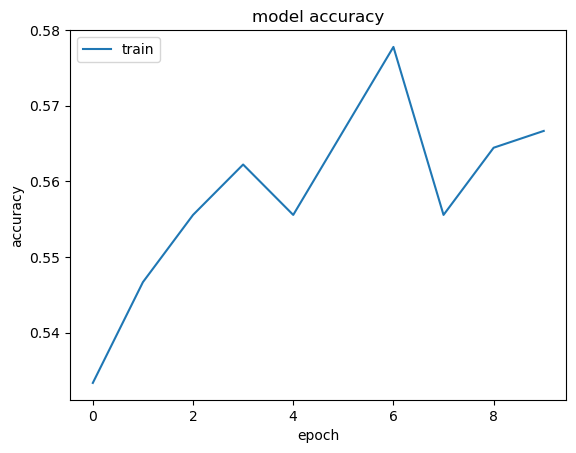

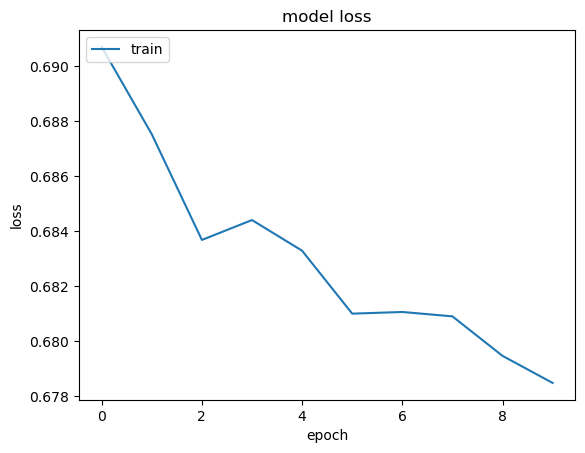

In [535]:
# Plot Accuracy over the epochs
plt.plot(classifier.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('model accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

# Plot Loss over the epochs
plt.plot(classifier.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('model loss')
plt.legend(['train'], loc='upper left')
plt.show()

In [536]:
# evaluate the keras model
loss, accuracy = model.evaluate(X_train[:1000], y_train[:1000])
print('Accuracy: %.2f' % (accuracy*100))
print(round(loss,3),round(accuracy,3))


15/15 [==============================] - 33s 2s/step - loss: 0.6763 - accuracy: 0.5667
Accuracy: 56.67
0.676 0.567


In [537]:
print(round(loss,3),round(accuracy,3))

0.676 0.567


# Test accuracy
Run model predictions on the test data set and report metrics scores, including MCC and F1 

In [538]:
from sklearn import metrics

# #Predict the testing set
predictions = (model.predict(X_test) > 0.5).astype(int)

#Accuracy classification score
acc = float(round(metrics.accuracy_score(y_test, predictions),3))

#Compute the balanced accuracy.
bacc = float(round(metrics.balanced_accuracy_score(y_test, predictions),3))

#Compute the Matthews correlation coefficient (MCC)
mcc = float(round(metrics.matthews_corrcoef(y_test, predictions),3))

#Compute the F1 score, also known as balanced F-score or F-measure.
f1 = float(round(metrics.f1_score(y_test, predictions),3))

#Show results as a DataFrame:
results = {'Accuracy' : [acc], 'Balanced Accuracy' : [bacc], 'MCC' : [mcc], 'F1-Score' : [f1]}
df_results = pd.DataFrame.from_dict(data = results, orient='columns')
print(df_results)

2/2 [==============================] - 9s 1s/step
   Accuracy  Balanced Accuracy    MCC  F1-Score
0      0.72               0.72  0.439     0.731
